In [27]:
import os
import glob
import functools
import itertools

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt

from invisible_cities.database.load_db                 import DataPMT
from invisible_cities.database.load_db                 import DataSiPM
from invisible_cities.reco    .calib_sensors_functions import calibrate_sipms
from invisible_cities.icaro   .hst_functions           import display_matrix
from invisible_cities.reco    .xy_algorithms           import corona

In [28]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams[  "font.size"   ] = 16

In [54]:
path = "/Users/Gonzalo/github/NEXTdata/runiii/rwf/run_{run_number}_0000_waveforms.h5"

_files_open = {}
def open_file(run_number):
    if run_number not in _files_open:
        _files_open[run_number] = tb.open_file(path.format(run_number=run_number))
    return _files_open[run_number]


def close_files():
    list(map(tb.File.close, _files_open.values()))

def load_run(run_number):
    file = open_file(run_number)
    return (file.root.RD.pmtrwf ,
            file.root.RD.pmtblr ,
            file.root.RD.sipmrwf)

In [55]:
def baricenter(wfs, thr=100):
    qs = np.sum(np.where(wfs > thr, wfs, 0), axis=1)
    return corona(xy_sipm, qs, lm_radius = -1)

In [56]:
run_numbers   = [5475, 5476, 5477, 5479, 5480, 5481, 5505, 5506, 5520, 5521, 5522, 5523]
gate_voltages = [ 7.5,  7.5,  7.5,  7.5,  7.5,  7.5,  7.5,  7.5,  7.5,  7.5,  7.5,  7.5]
cath_voltages = [  30,   25,   20,   15,   10,    9,    6,  6.3,  6.3,  6.3,  6.3,  6.3]
runs          = zip(*map(load_run, run_numbers))

gate_voltage = dict(zip(run_numbers, gate_voltages))
cath_voltage = dict(zip(run_numbers, cath_voltages))
pmtrwf       = dict(zip(run_numbers,    next(runs)))
pmtblr       = dict(zip(run_numbers,    next(runs)))
sipmrwf      = dict(zip(run_numbers,    next(runs)))

In [41]:
datapmt  = DataPMT (run_numbers[0])
datasipm = DataSiPM(run_numbers[0])

x_sipm   = datasipm.X.values
y_sipm   = datasipm.Y.values
xy_sipm  = np.column_stack((x_sipm, y_sipm))

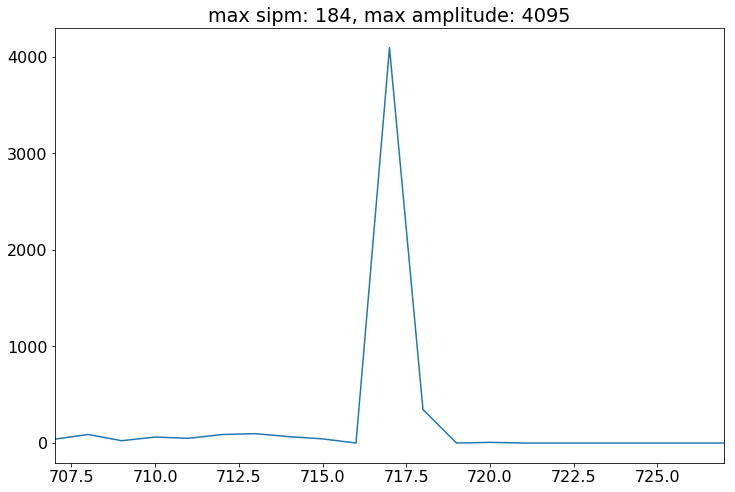

[< nsipm = 1792 Q = 872468
                    xy = xy(x=-44.94442203037819, y=26.07844643012695) 3dHit = Cluster(-44.94442203037819, 26.07844643012695, -9.425, E=872468)  >]


In [46]:
evt = sipmrwf[5522][5]
sipm, center = np.unravel_index(np.argmax(evt), evt.shape)
window = 10
plt.plot(evt[sipm])
plt.xlim(center - window, center + window)
plt.title(f"max sipm: {sipm}, max amplitude: {np.max(evt)}")
plt.show()
print(baricenter(evt, 200))

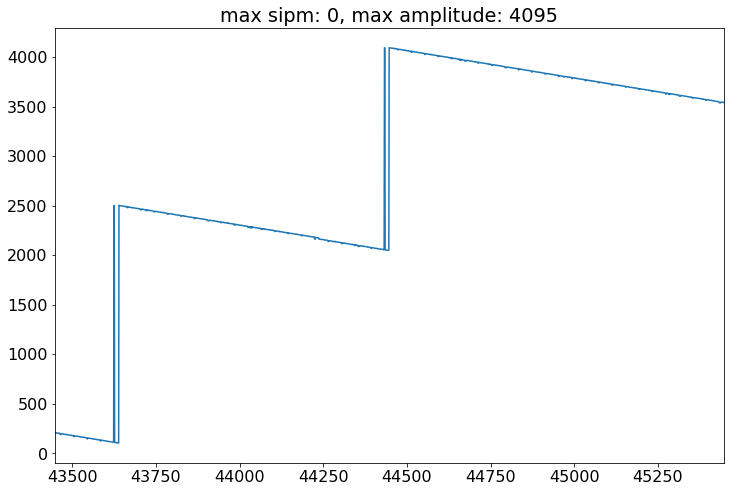

[< nsipm = 12 Q = 2176910633
                    xy = xy(x=-231.65835865757379, y=73.21533521812698) 3dHit = Cluster(-231.65835865757379, 73.21533521812698, -9.425, E=2176910633)  >]


In [70]:
evt = pmtblr[5523][5]
sipm, center = np.unravel_index(np.argmax(evt), evt.shape)
window = 1000
plt.plot(evt[sipm])
plt.xlim(center - window, center + window)
plt.title(f"max sipm: {sipm}, max amplitude: {np.max(evt)}")
plt.show()
print(baricenter(evt, 200))

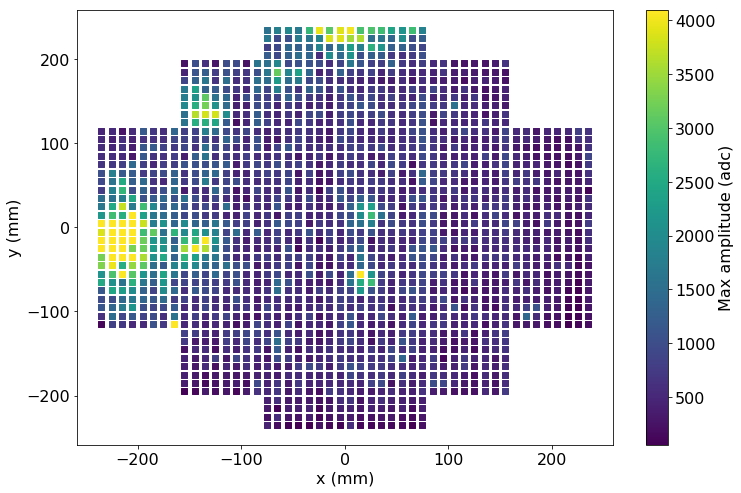

In [74]:
evt   = sipmrwf[5523][0]
maxes = np.max(evt, axis=1)
plt.scatter(x_sipm, y_sipm, c=maxes, marker="s")
plt.colorbar().set_label("Max amplitude (adc)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

In [77]:
datasipm[datasipm.SensorID // 1000 == 22].mean()

SensorID      22031.500000
ChannelID     22031.500000
Active            0.984375
X               120.000000
Y                80.000000
adc_to_pes       15.737832
dtype: float64

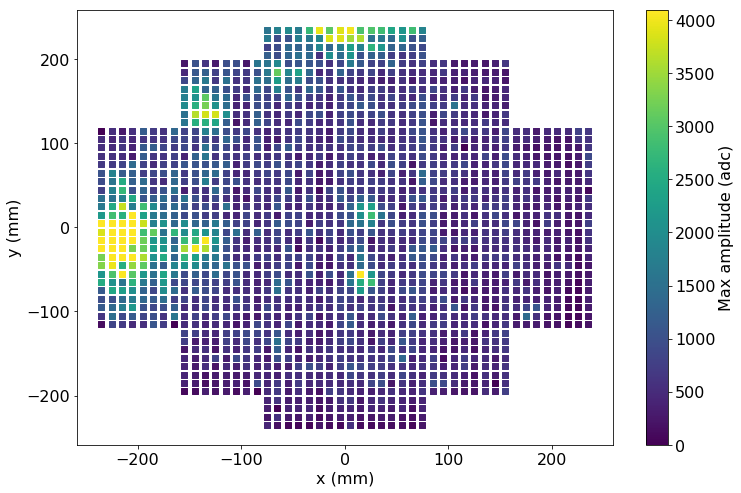

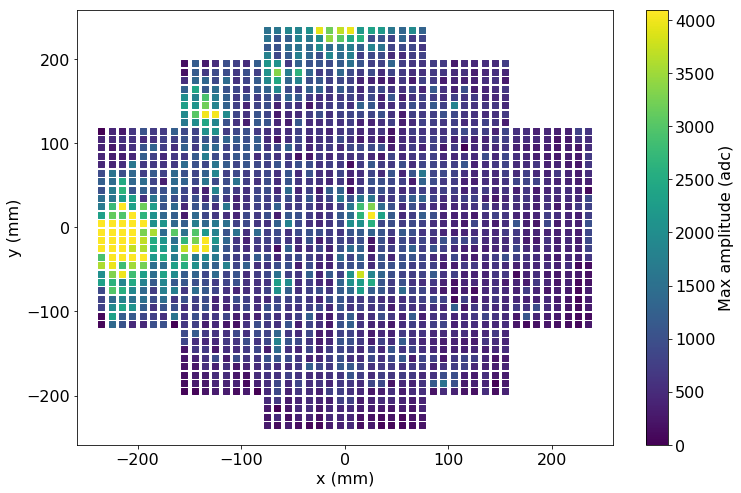

KeyboardInterrupt: 

In [49]:
evts   = sipmrwf[5523]
for evt in evts:
    maxes = np.max(evt, axis=1) * datasipm.Active.values
    plt.scatter(x_sipm, y_sipm, c=maxes, marker="s")
    plt.colorbar().set_label("Max amplitude (adc)")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.show()
    input()

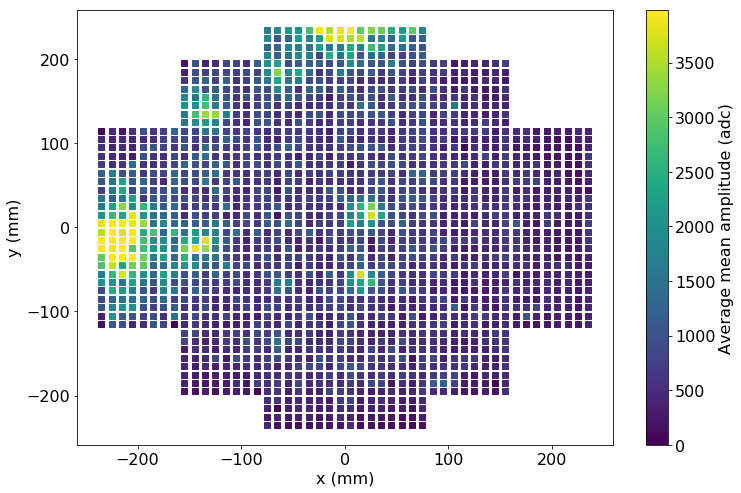

In [57]:
evts  = sipmrwf[5523]
maxes = np.max ( evts, axis=2) * datasipm.Active.values
means = np.mean(maxes, axis=0)
plt.scatter(x_sipm, y_sipm, c=means, marker="s")
plt.colorbar().set_label("Average mean amplitude (adc)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

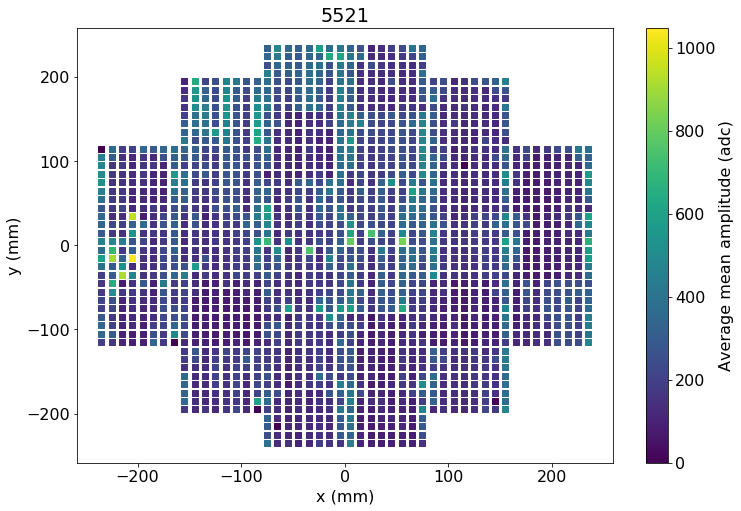

In [69]:
run_number = 5521
pmt_thr    = 1400

is_saturated = lambda x: np.max(x) > pmt_thr
saturates    = np.apply_along_axis(is_saturated, 2, pmtblr[run_number])
valid        = np.all(saturates, axis=1)

evts       = sipmrwf[run_number]
maxes      = np.max ( evts[:][valid], axis=2) * datasipm.Active.values
means      = np.mean(maxes          , axis=0)

plt.scatter(x_sipm, y_sipm, c=means, marker="s")
plt.colorbar().set_label("Average mean amplitude (adc)")
plt.title  (f"{run_number}")
plt.xlabel ( "x (mm)")
plt.ylabel ( "y (mm)")
plt.savefig(f"/Users/Gonzalo/Desktop/sipm_saturation_{run_number}.png")